In [3]:
from scipy import stats
from scipy.stats import ttest_1samp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

### На сайте запущен А/В тест с целью увеличить доход. В приложенном excel файле вы найдете сырые данные по результатам эксперимента – user_id, тип выборки variant_name и доход принесенный пользователем revenue. Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.

In [4]:
df = pd.read_excel('AB_Test_Results (2) (1).xlsx')
df

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
...,...,...,...
9995,1981,control,0.0
9996,502,variant,0.0
9997,9214,variant,0.0
9998,7741,control,0.0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


#### Проверим есть ли в данных повторяющиеся значения.
1) сгруппируем данные по USER_ID и посмотрим количество повторений:

In [69]:
df.USER_ID.value_counts()

5652    6
8359    6
668     6
9101    6
4879    6
       ..
5455    1
1399    1
6967    1
3156    1
9468    1
Name: USER_ID, Length: 6324, dtype: int64

In [70]:
df.query('USER_ID == 5652')

,USER_ID,VARIANT_NAME,REVENUE
595,5652,control,0.0
778,5652,control,0.0
2880,5652,control,0.0
6327,5652,control,0.0
7248,5652,control,0.0
7972,5652,control,0.0


In [73]:
df.query('USER_ID == 4879')

,USER_ID,VARIANT_NAME,REVENUE
220,4879,control,0.0
2928,4879,control,0.0
5667,4879,control,0.0
5899,4879,control,0.0
6506,4879,variant,0.0
7353,4879,variant,0.0


#### Видим, что один и тот же USER_ID может присутствовать в нескольких строках и в нескольких группах VARIANT_NAME. Если первый случай можно объяснить тем, что клиент заходил на сайт несколько раз, то второй случай явно относится к некорректной системе сплитования. Для оценки данных будет лучшим исключить те USER_ID, которые попадают в контрольную и тестовую группу.

2) сгруппируем данные по USER_ID и агрегируем их по тестовым группам

In [16]:
copi = df.\
            groupby('USER_ID', as_index=False).\
            agg({'VARIANT_NAME': pd.Series.nunique})
copi        

,USER_ID,VARIANT_NAME
0,2,1
1,3,2
2,4,1
3,5,1
4,6,1
...,...,...
6319,9993,1
6320,9995,1
6321,9996,2
6322,9998,1


3) оставим в данных только строки, где USER_ID попадает лишь в одну группу:

In [92]:
df_VARIANT_NAME_1 = copi.query('VARIANT_NAME == 1')
df_VARIANT_NAME_1

,USER_ID,VARIANT_NAME
0,2,1
2,4,1
3,5,1
4,6,1
5,9,1
...,...,...
6317,9990,1
6318,9992,1
6319,9993,1
6320,9995,1


In [95]:
df_var_1 = df[df.USER_ID.isin(df_VARIANT_NAME_1.USER_ID)]
df_var_1

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
4,6174,variant,0.0
5,2380,variant,0.0
7,9168,control,0.0
9,7548,control,0.0
...,...,...,...
9993,2400,variant,0.0
9994,3129,control,0.0
9996,502,variant,0.0
9998,7741,control,0.0


4) так как нас интересует аналитика по совершенным покупкам, то выберем те строки, где revenue > 0

In [124]:
df_clean = df_var_1[df_var_1['REVENUE'] > 0]
df_clean

,USER_ID,VARIANT_NAME,REVENUE
49,6429,control,3.25
139,3331,variant,4.27
149,8110,variant,1.75
152,8607,control,2.99
333,8020,control,9.91
...,...,...,...
9466,6623,control,1.78
9612,1035,control,0.23
9651,9928,variant,1.25
9711,6468,control,2.93


#### Процент покупок больше 0:

In [127]:
df_clean['REVENUE'].count()/df['REVENUE'].count()*100

0.97

#### Разобьем данные на две группы А (control) и В (variant). Посмотрим краткую статистику по двум группам.

In [98]:
df_A = df_clean[df_clean['VARIANT_NAME'] == 'control']
df_A.describe()

,USER_ID,REVENUE
count,54.000000,54.000000
mean,4283.851852,8.714074
std,2846.713818,26.627446
min,124.000000,0.020000
25%,1947.500000,1.585000
50%,3617.500000,3.120000
75%,6458.250000,6.007500
max,9766.000000,196.010000


In [99]:
df_B = df_clean[df_clean['VARIANT_NAME'] == 'variant']
df_B.describe()

,USER_ID,REVENUE
count,43.000000,43.000000
mean,5297.534884,4.170233
std,3067.761518,4.932851
min,56.000000,0.020000
25%,3328.500000,1.250000
50%,4995.000000,2.720000
75%,8011.000000,4.270000
max,9928.000000,23.040000


#### Проверим данные на нормальность распределения:

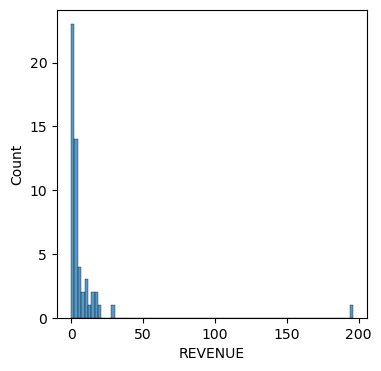

In [105]:
plt.figure(figsize=(4, 4))
sns.histplot(df_A, x= 'REVENUE');

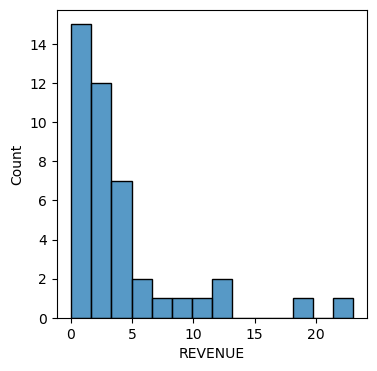

In [106]:
plt.figure(figsize=(4, 4))
sns.histplot(df_B, x= 'REVENUE');

#### Данные явно распределены не нормально. К тому же в контрольной группе имеется значительный выброс. Исключим его из выборки.

In [116]:
df_A = df_A[df_A['REVENUE'] < 50]
df_A.describe()

,USER_ID,REVENUE
count,53.000000,53.000000
mean,4301.622642,5.180189
std,2870.930211,5.942771
min,124.000000,0.020000
25%,1939.000000,1.560000
50%,3699.000000,2.990000
75%,6468.000000,4.980000
max,9766.000000,29.320000


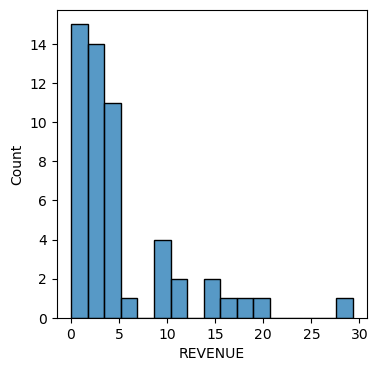

In [110]:
plt.figure(figsize=(4, 4))
sns.histplot(df_A, x= 'REVENUE');

#### Распределения не нормальные в двух группах, поэтому воспользуемся критерием Манна-Уитни. Альфа = 0.05.
#### Нулевая гипотеза: различий в двух группах нет. Альтернативная: изменения есть в ту или иную сторону.

In [118]:
mw_stats = stats.mannwhitneyu(x=df_A.REVENUE, y=df_B.REVENUE)
mw_stats

MannwhitneyuResult(statistic=1249.0, pvalue=0.4218148352342157)

#### р-значение меньше альфы (0,05), следовательно верна альтернативная гипотеза: тестовая группа статистически значимо отличается от контрольной
#### Посмотрим в какой стороне тестовые данные: 

In [120]:
df_A.REVENUE.sum()

274.55

In [121]:
df_B.REVENUE.sum()

179.32

#### Как видим предпринятые изменения с целью увеличить доход были не успешны: доход в тестовой группе упал с  статистически значимой вероятносью в 95%.
### Рекомендации менеджеру:  
1) данный эксперимент проведен некорректно по системе сплитования. Рекомендуется проверить данную систему на корректность работы и провести эксперимент заново, если будет необходимость.
2) в данных REVENUE строк с покупкой больше 0 меньше 1%. Возможно стоит проанализировать почему конверсия в покупку столь мала. 
3) по результату тестирования предоставленных данных, тестируемые изменения не использовать, искать другие способы увеличить доход. 